# The Oscars

## Librerías y lectura de datos

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from collections import Counter
warnings.filterwarnings("ignore")

In [2]:
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["figure.dpi"] = 120
sns.set_theme(style="whitegrid", palette="muted")

In [3]:
df = pd.read_csv("data/master_dataset.csv")
print(f"Shape: {df.shape}")
df.head(3)

Shape: (170, 62)


,ceremony_year,nominated_title,won_best_picture,tmdb_id,tmdb_title,synopsis,tagline,budget,revenue,runtime_min,...,genre_comedy,genre_biography,genre_history,genre_romance,genre_thriller,genre_war,rt_norm,imdb_norm,metacritic_norm,critic_composite
0,2025,Anora,1,1064213,Anora,A young sex worker from Brooklyn gets her chan...,Love is a hustle.,6000000,56286295,139,...,1,0,0,1,0,0,93.0,74.0,91.0,86.000000
1,2025,The Brutalist,0,549509,The Brutalist,When an innovative modern architect flees post...,Welcome to America.,9600000,50145227,215,...,0,0,0,0,0,0,93.0,73.0,90.0,85.333333
2,2025,A Complete Unknown,0,661539,A Complete Unknown,"New York, early 1960s. Against the backdrop of...",The ballad of a true original.,65000000,138003641,140,...,0,0,0,0,0,0,82.0,73.0,70.0,75.000000


In [29]:
df.columns

Index(['ceremony_year', 'nominated_title', 'won_best_picture', 'tmdb_id',
       'tmdb_title', 'synopsis', 'tagline', 'budget', 'revenue', 'runtime_min',
       'release_date', 'original_language', 'genres', 'tmdb_popularity',
       'tmdb_vote_avg', 'tmdb_vote_count', 'director', 'cast_top5',
       'production_companies', 'imdb_id', 'imdb_rating', 'imdb_votes',
       'metacritic', 'rt_score', 'box_office_usd', 'rated', 'omdb_awards',
       'country', 'language', 'BAFTA_best_film_won', 'CCA_best_picture_won',
       'GG_comedy_won', 'GG_drama_won', 'PGA_best_picture_won',
       'CCA_best_picture_nominated', 'GG_drama_nominated',
       'PGA_best_picture_nominated', 'GG_comedy_nominated',
       'BAFTA_best_film_nominated', 'budget_m', 'revenue_m', 'log_budget',
       'log_revenue', 'roi', 'log_imdb_votes', 'release_month',
       'is_q4_release', 'is_english', 'total_precursor_wins',
       'total_precursor_noms', 'omdb_oscar_wins', 'genre_drama',
       'genre_comedy', 'genre_bio

## Valores Faltantes

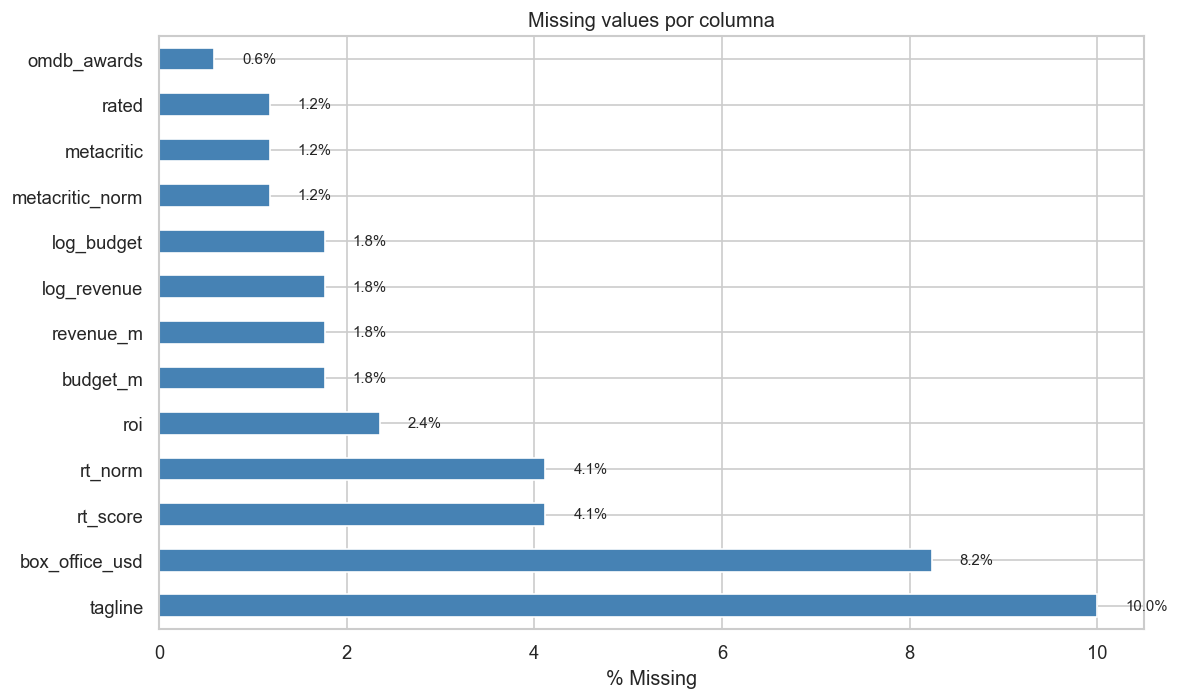

In [4]:
missing = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
missing = missing[missing > 0]

fig, ax = plt.subplots(figsize=(10, 6))
missing.plot(kind="barh", ax=ax, color="steelblue")
ax.set_xlabel("% Missing")
ax.set_title("Missing values por columna")
for i, v in enumerate(missing):
    ax.text(v + 0.3, i, f"{v:.1f}%", va="center", fontsize=9)
plt.tight_layout()
plt.show()

# Visualizaciones

### Géneros

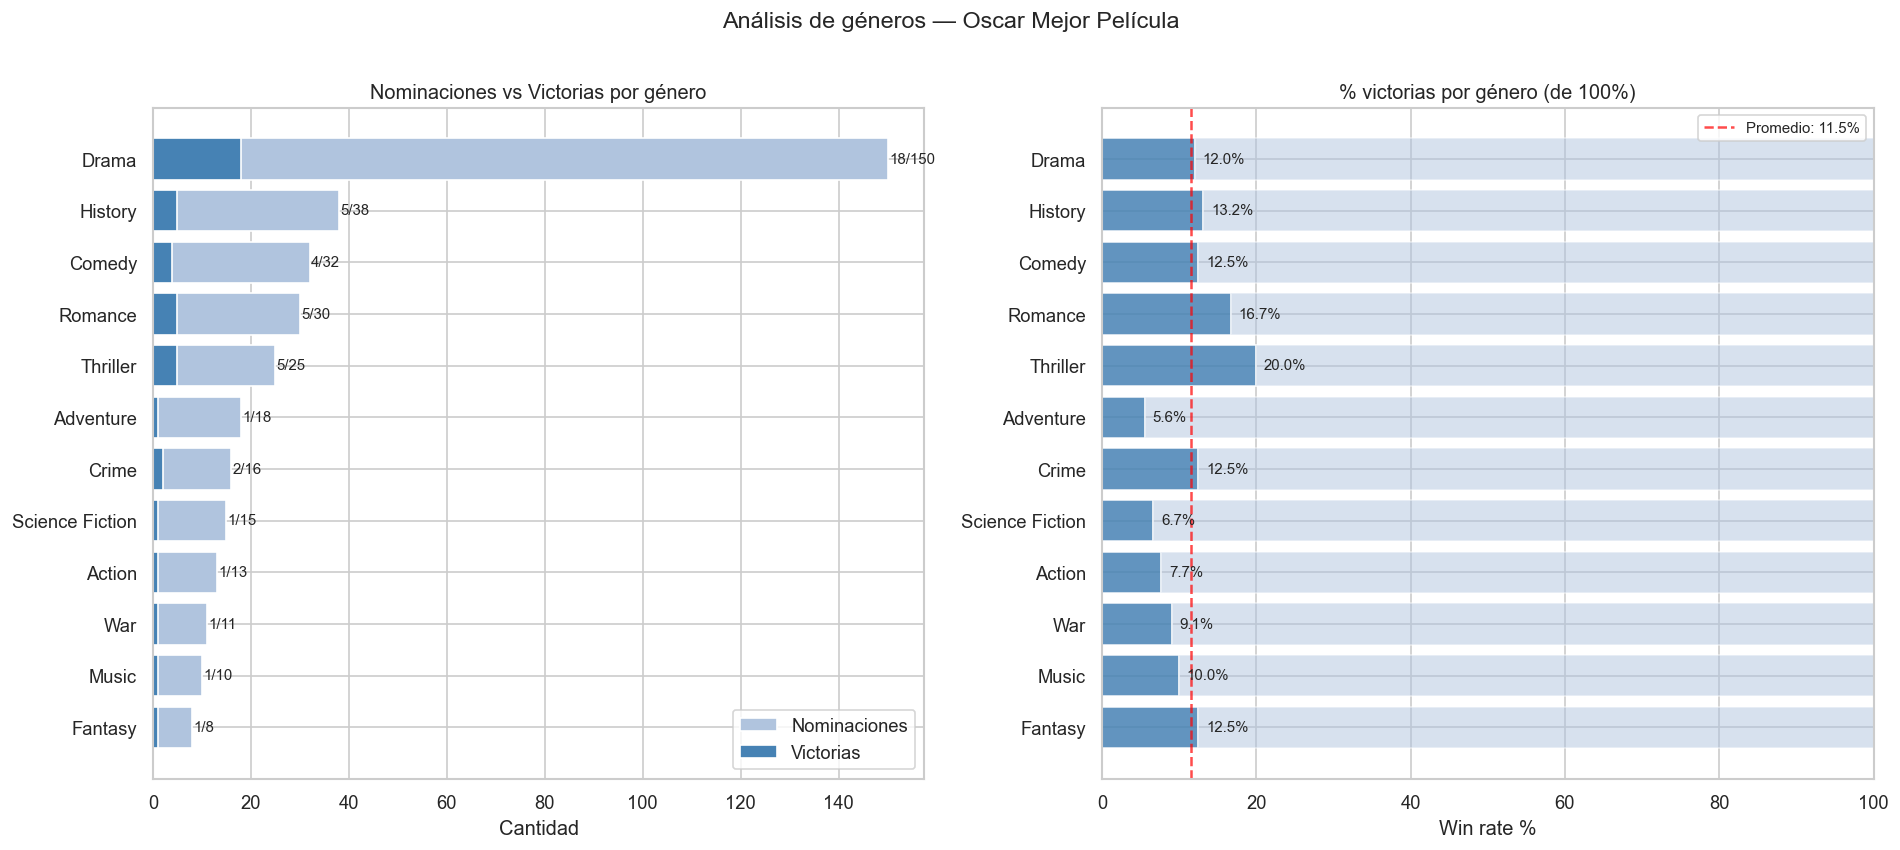

In [18]:
from collections import Counter

genre_rows = []
for _, row in df.iterrows():
    try:
        genres = json.loads(row["genres"]) if pd.notna(row["genres"]) else []
    except:
        genres = []
    for g in genres:
        genre_rows.append({"genre": g, "won": row["won_best_picture"]})

genre_df = pd.DataFrame(genre_rows)

summary = genre_df.groupby("genre").agg(
    nominaciones=("won", "count"),
    victorias=("won", "sum")
).sort_values("nominaciones", ascending=False).head(12)
summary["win_rate"] = summary["victorias"] / summary["nominaciones"] * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# ── Izquierda: nominaciones vs victorias ──────────────────────────────
ax = axes[0]
ax.barh(summary.index, summary["nominaciones"], color="lightsteelblue", label="Nominaciones")
ax.barh(summary.index, summary["victorias"],    color="steelblue",      label="Victorias")
ax.invert_yaxis()
ax.set_xlabel("Cantidad")
ax.set_title("Nominaciones vs Victorias por género")
ax.legend()
for i, (nom, vic) in enumerate(zip(summary["nominaciones"], summary["victorias"])):
    ax.text(nom + 0.3, i, f"{vic}/{nom}", va="center", fontsize=9)

# ── Derecha: win rate 0-100% ──────────────────────────────────────────
ax = axes[1]
ax.barh(summary.index, summary["win_rate"], color="steelblue", alpha=0.85)
ax.barh(summary.index, 100 - summary["win_rate"],
        left=summary["win_rate"], color="lightsteelblue", alpha=0.5)
ax.invert_yaxis()
ax.set_xlabel("Win rate %")
ax.set_title("% victorias por género (de 100%)")
ax.set_xlim(0, 100)
ax.axvline(summary["win_rate"].mean(), color="red", linestyle="--", alpha=0.7,
           label=f"Promedio: {summary['win_rate'].mean():.1f}%")
ax.legend(fontsize=9)
for i, val in enumerate(summary["win_rate"]):
    ax.text(val + 1, i, f"{val:.1f}%", va="center", fontsize=9)

plt.suptitle("Análisis de géneros — Oscar Mejor Película", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

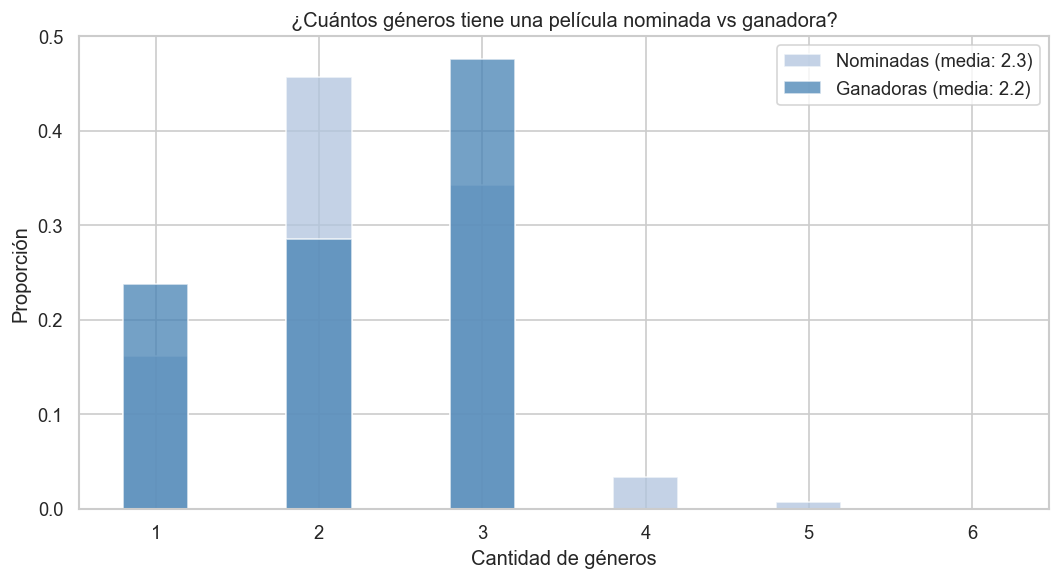

In [19]:
df["n_genres"] = df["genres"].apply(lambda g: len(json.loads(g)) if pd.notna(g) else 0)

fig, ax = plt.subplots(figsize=(9, 5))
for won, label, color in [(0, "Nominadas", "lightsteelblue"), (1, "Ganadoras", "steelblue")]:
    sub = df[df["won_best_picture"] == won]["n_genres"]
    ax.hist(sub, bins=range(1, 8), alpha=0.75, color=color, label=f"{label} (media: {sub.mean():.1f})",
            align="left", rwidth=0.4, density=True)

ax.set_title("¿Cuántos géneros tiene una película nominada vs ganadora?")
ax.set_xlabel("Cantidad de géneros")
ax.set_ylabel("Proporción")
ax.set_xticks(range(1, 7))
ax.legend()
plt.tight_layout()
plt.show()

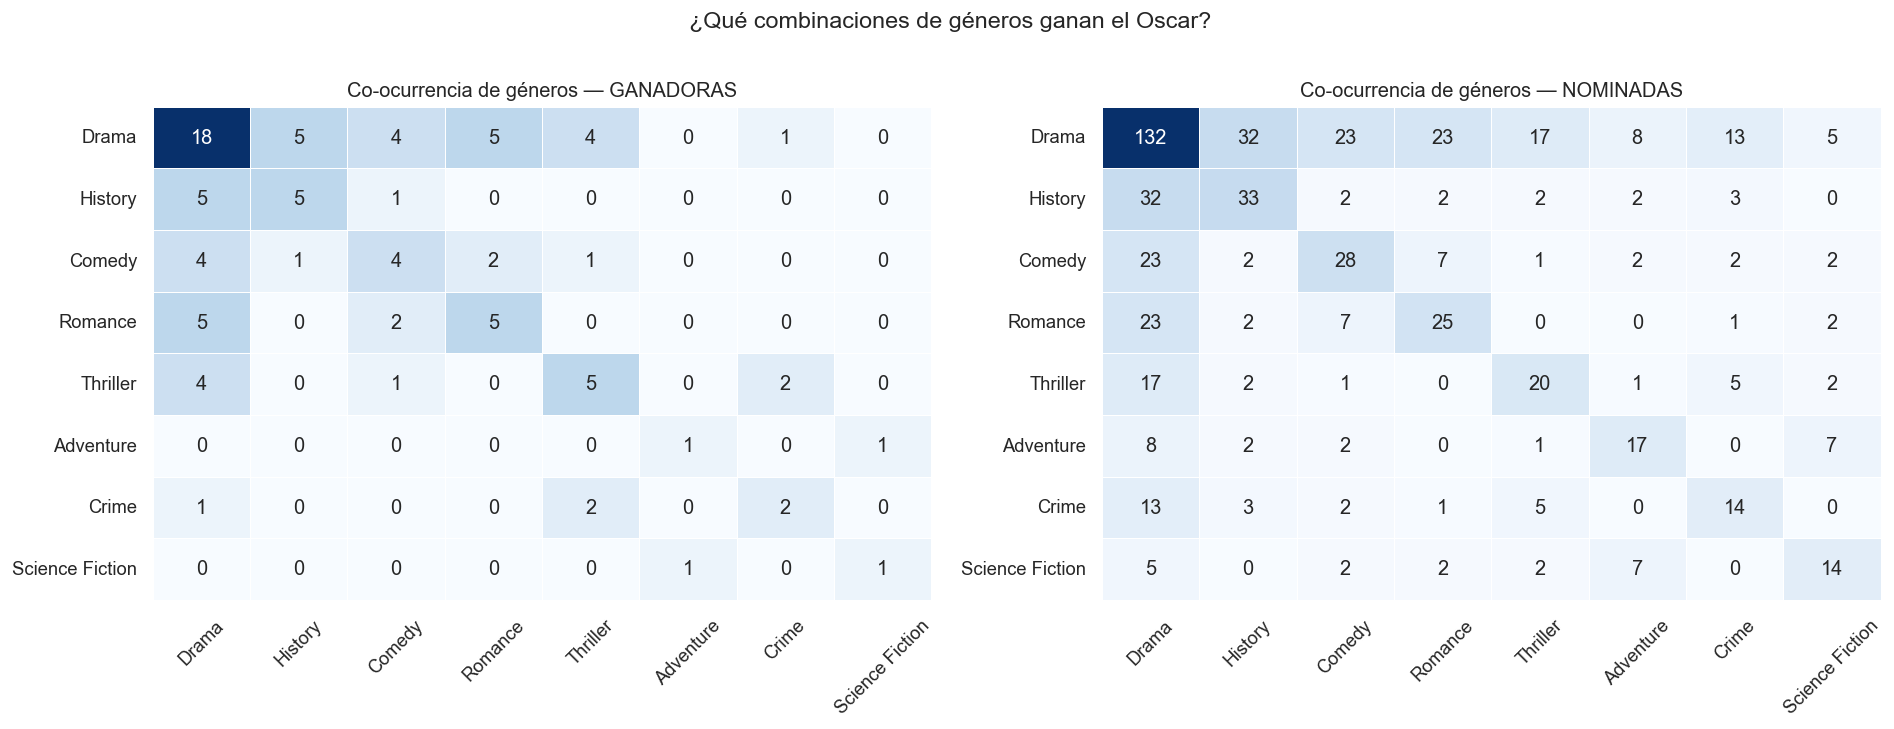

In [20]:
from itertools import combinations

top_genres = summary.head(8).index.tolist()

def cooccurrence_matrix(subdf, genres):
    matrix = pd.DataFrame(0, index=genres, columns=genres)
    for _, row in subdf.iterrows():
        try:
            g = [x for x in json.loads(row["genres"]) if x in genres]
        except:
            g = []
        for g1, g2 in combinations(g, 2):
            matrix.loc[g1, g2] += 1
            matrix.loc[g2, g1] += 1
        for g1 in g:
            matrix.loc[g1, g1] += 1
    return matrix

winners_matrix = cooccurrence_matrix(df[df["won_best_picture"] == 1], top_genres)
losers_matrix  = cooccurrence_matrix(df[df["won_best_picture"] == 0], top_genres)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, matrix, title in zip(axes,
    [winners_matrix, losers_matrix],
    ["Co-ocurrencia de géneros — GANADORAS", "Co-ocurrencia de géneros — NOMINADAS"]):
    
    sns.heatmap(matrix, ax=ax, annot=True, fmt="d", cmap="Blues",
                linewidths=0.5, cbar=False)
    ax.set_title(title, fontsize=12)
    ax.tick_params(axis="x", rotation=45)

plt.suptitle("¿Qué combinaciones de géneros ganan el Oscar?", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

### Budget - revenue - runtime

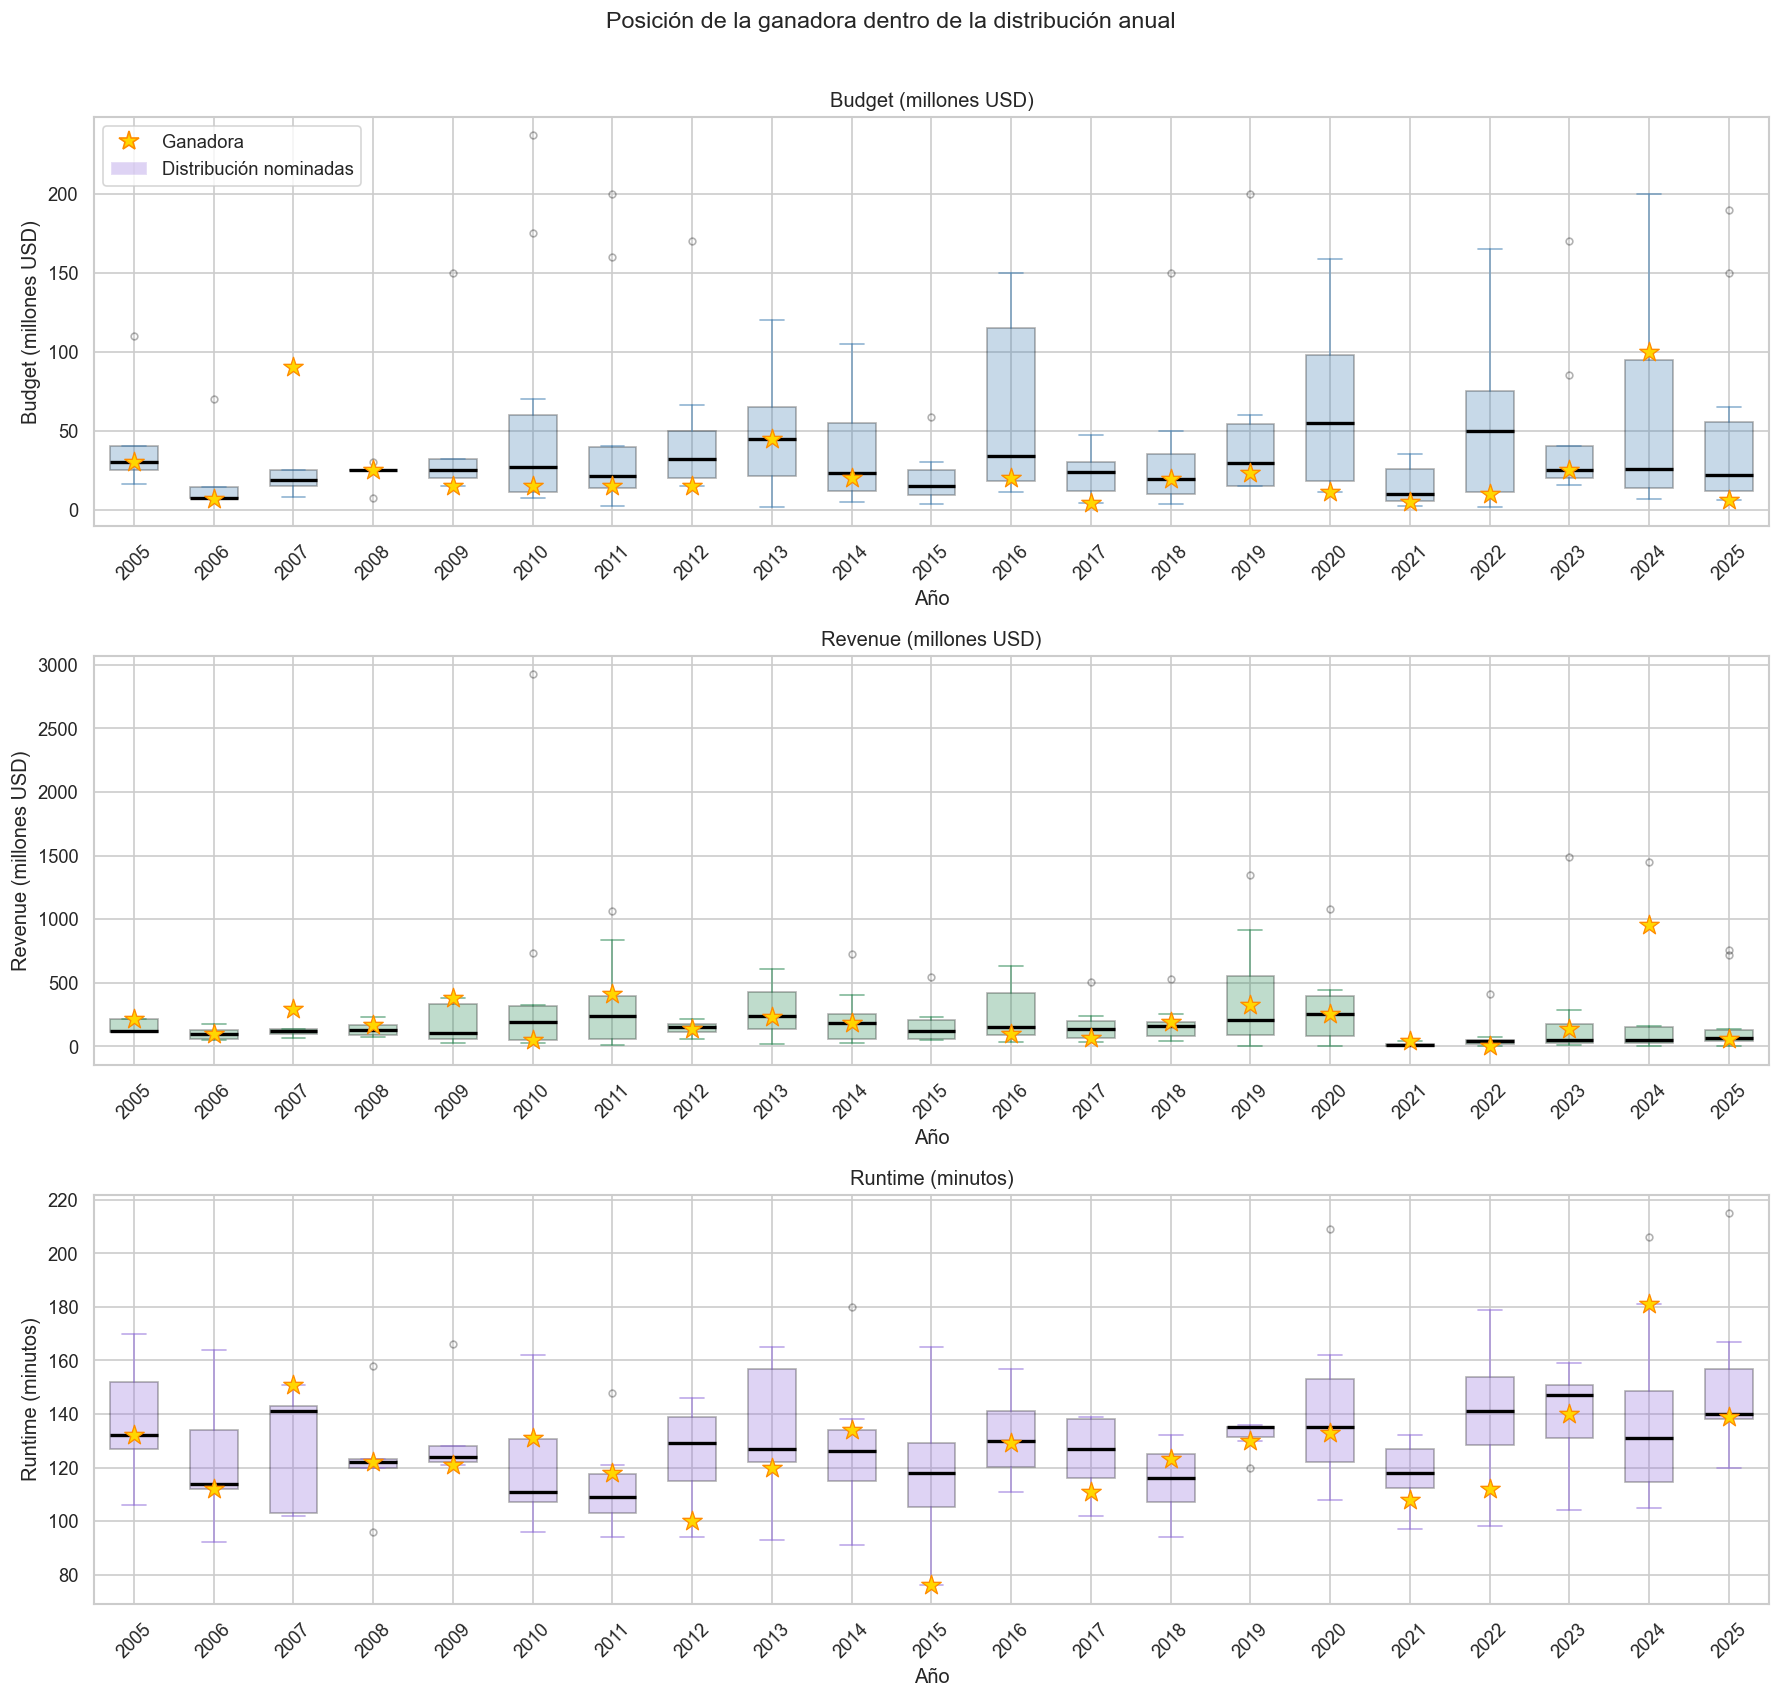

In [22]:
fig, axes = plt.subplots(3, 1, figsize=(15, 14))

metrics = [
    ("budget_m",    "Budget (millones USD)",  "steelblue"),
    ("revenue_m",   "Revenue (millones USD)", "seagreen"),
    ("runtime_min", "Runtime (minutos)",      "mediumpurple"),
]

for ax, (col, title, color) in zip(axes, metrics):
    for year in sorted(df["ceremony_year"].unique()):
        year_df  = df[df["ceremony_year"] == year][col].dropna()
        winner   = df[(df["ceremony_year"] == year) & (df["won_best_picture"] == 1)][col]
        
        if year_df.empty:
            continue
        
        # Boxplot por año
        bp = ax.boxplot(year_df, positions=[year], widths=0.6,
                        patch_artist=True,
                        boxprops=dict(facecolor=color, alpha=0.3),
                        medianprops=dict(color="black", linewidth=2),
                        whiskerprops=dict(color=color, alpha=0.6),
                        capprops=dict(color=color, alpha=0.6),
                        flierprops=dict(marker="o", color=color, alpha=0.3, markersize=4))
        
        # Ganadora como estrella
        if not winner.empty and pd.notna(winner.values[0]):
            ax.scatter(year, winner.values[0], color="gold", s=150,
                      zorder=5, marker="*", edgecolors="darkorange", linewidth=0.8)

    ax.set_title(title)
    ax.set_xlabel("Año")
    ax.set_ylabel(title)
    ax.set_xticks(sorted(df["ceremony_year"].unique()))
    ax.tick_params(axis="x", rotation=45)

# Leyenda manual
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker="*", color="w", markerfacecolor="gold",
           markeredgecolor="darkorange", markersize=12, label="Ganadora"),
    plt.Rectangle((0,0), 1, 1, fc=color, alpha=0.3, label="Distribución nominadas")
]
axes[0].legend(handles=legend_elements, loc="upper left")

plt.suptitle("Posición de la ganadora dentro de la distribución anual", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

### Alguna vez, gano una peli que no sea originalmente en inglés?

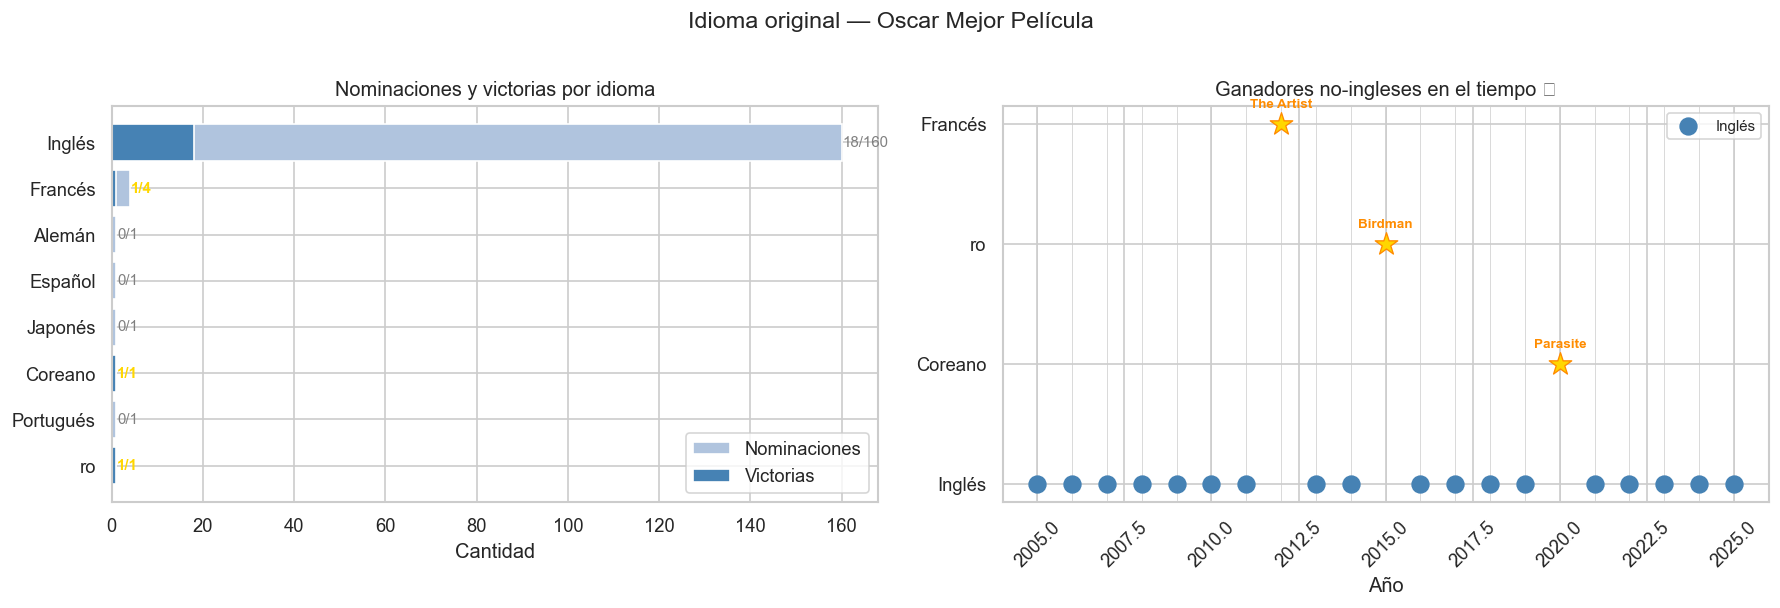

In [23]:
lang_summary = df.groupby("original_language").agg(
    nominaciones=("won_best_picture", "count"),
    victorias=("won_best_picture", "sum")
).sort_values("nominaciones", ascending=False)
lang_summary["win_rate"] = lang_summary["victorias"] / lang_summary["nominaciones"] * 100

# Mapear códigos a nombres
lang_names = {
    "en": "Inglés", "fr": "Francés", "ko": "Coreano", "es": "Español",
    "de": "Alemán", "it": "Italiano", "ja": "Japonés", "ar": "Árabe",
    "pt": "Portugués", "zh": "Chino", "ru": "Ruso", "fa": "Persa"
}
lang_summary.index = [lang_names.get(x, x) for x in lang_summary.index]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ── Nominaciones vs victorias ─────────────────────────────────────────
ax = axes[0]
ax.barh(lang_summary.index, lang_summary["nominaciones"], color="lightsteelblue", label="Nominaciones")
ax.barh(lang_summary.index, lang_summary["victorias"],    color="steelblue",      label="Victorias")
ax.invert_yaxis()
ax.set_title("Nominaciones y victorias por idioma")
ax.set_xlabel("Cantidad")
ax.legend()
for i, (nom, vic) in enumerate(zip(lang_summary["nominaciones"], lang_summary["victorias"])):
    label = f"{int(vic)}/{int(nom)}"
    color = "gold" if vic > 0 and lang_summary.index[i] != "Inglés" else "gray"
    ax.text(nom + 0.2, i, label, va="center", fontsize=9,
            fontweight="bold" if color == "gold" else "normal", color=color)

# ── Línea temporal: ganadores no-ingleses ─────────────────────────────
ax = axes[1]
non_english_winners = df[(df["won_best_picture"] == 1) & (df["original_language"] != "en")]
all_winners = df[df["won_best_picture"] == 1]

# Fondo: todos los años
for year in sorted(df["ceremony_year"].unique()):
    ax.axvline(year, color="lightgray", linewidth=0.5, zorder=0)

# Ganadores en inglés
english_w = all_winners[all_winners["original_language"] == "en"]
ax.scatter(english_w["ceremony_year"], ["Inglés"] * len(english_w),
           color="steelblue", s=100, zorder=3, label="Inglés")

# Ganadores no inglés — destacados
for _, row in non_english_winners.iterrows():
    lang = lang_names.get(row["original_language"], row["original_language"])
    ax.scatter(row["ceremony_year"], lang, color="gold", s=200, zorder=5,
               marker="*", edgecolors="darkorange", linewidth=0.8)
    ax.annotate(row["nominated_title"], (row["ceremony_year"], lang),
                textcoords="offset points", xytext=(0, 10), fontsize=8,
                ha="center", color="darkorange", fontweight="bold")

ax.set_title("Ganadores no-ingleses en el tiempo ⭐")
ax.set_xlabel("Año")
ax.tick_params(axis="x", rotation=45)
ax.legend(fontsize=9)

plt.suptitle("Idioma original — Oscar Mejor Película", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

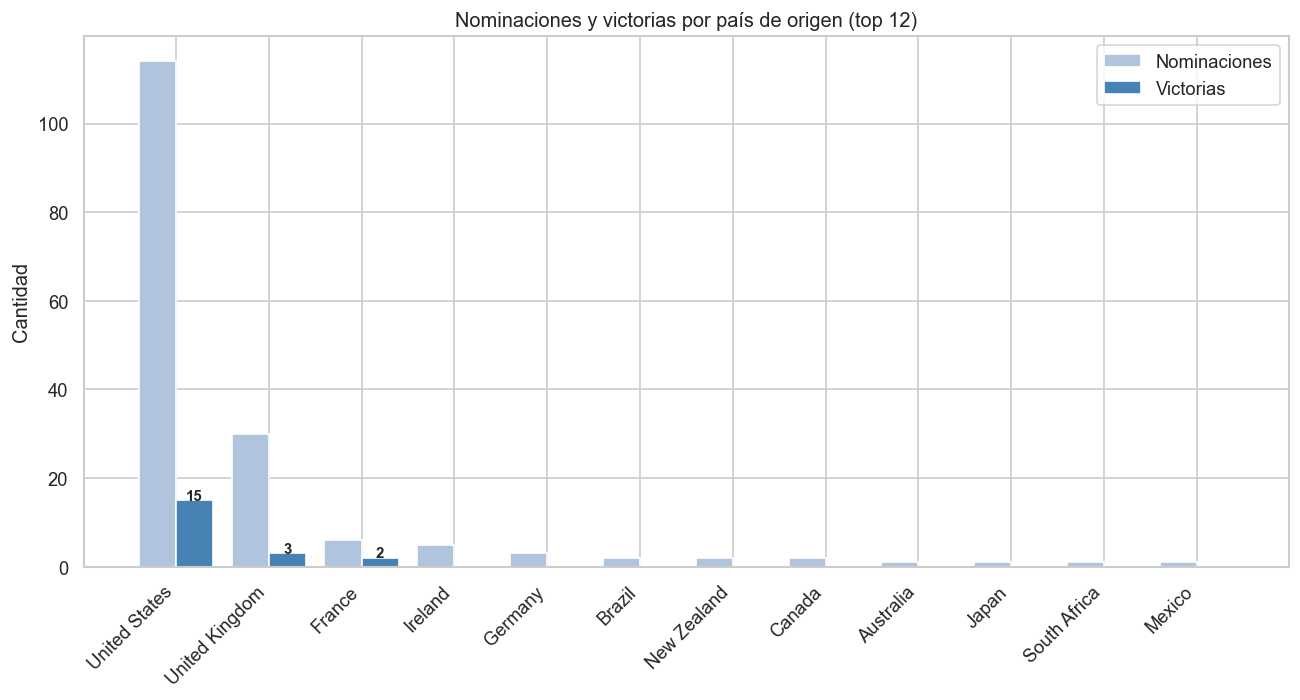

In [24]:
# Tomar el primer país listado
df["primary_country"] = df["country"].apply(
    lambda x: str(x).split(",")[0].strip() if pd.notna(x) else "Unknown"
)

country_summary = df.groupby("primary_country").agg(
    nominaciones=("won_best_picture", "count"),
    victorias=("won_best_picture", "sum")
).sort_values("nominaciones", ascending=False).head(12)
country_summary["win_rate"] = country_summary["victorias"] / country_summary["nominaciones"] * 100

fig, ax = plt.subplots(figsize=(11, 6))
x = np.arange(len(country_summary))
width = 0.4

bars1 = ax.bar(x - width/2, country_summary["nominaciones"], width,
               color="lightsteelblue", label="Nominaciones")
bars2 = ax.bar(x + width/2, country_summary["victorias"],    width,
               color="steelblue",      label="Victorias")

ax.set_xticks(x)
ax.set_xticklabels(country_summary.index, rotation=45, ha="right")
ax.set_title("Nominaciones y victorias por país de origen (top 12)")
ax.set_ylabel("Cantidad")
ax.legend()

for bar in bars2:
    if bar.get_height() > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f"{int(bar.get_height())}", ha="center", fontsize=9, fontweight="bold")

plt.tight_layout()
plt.show()

### Popularidad

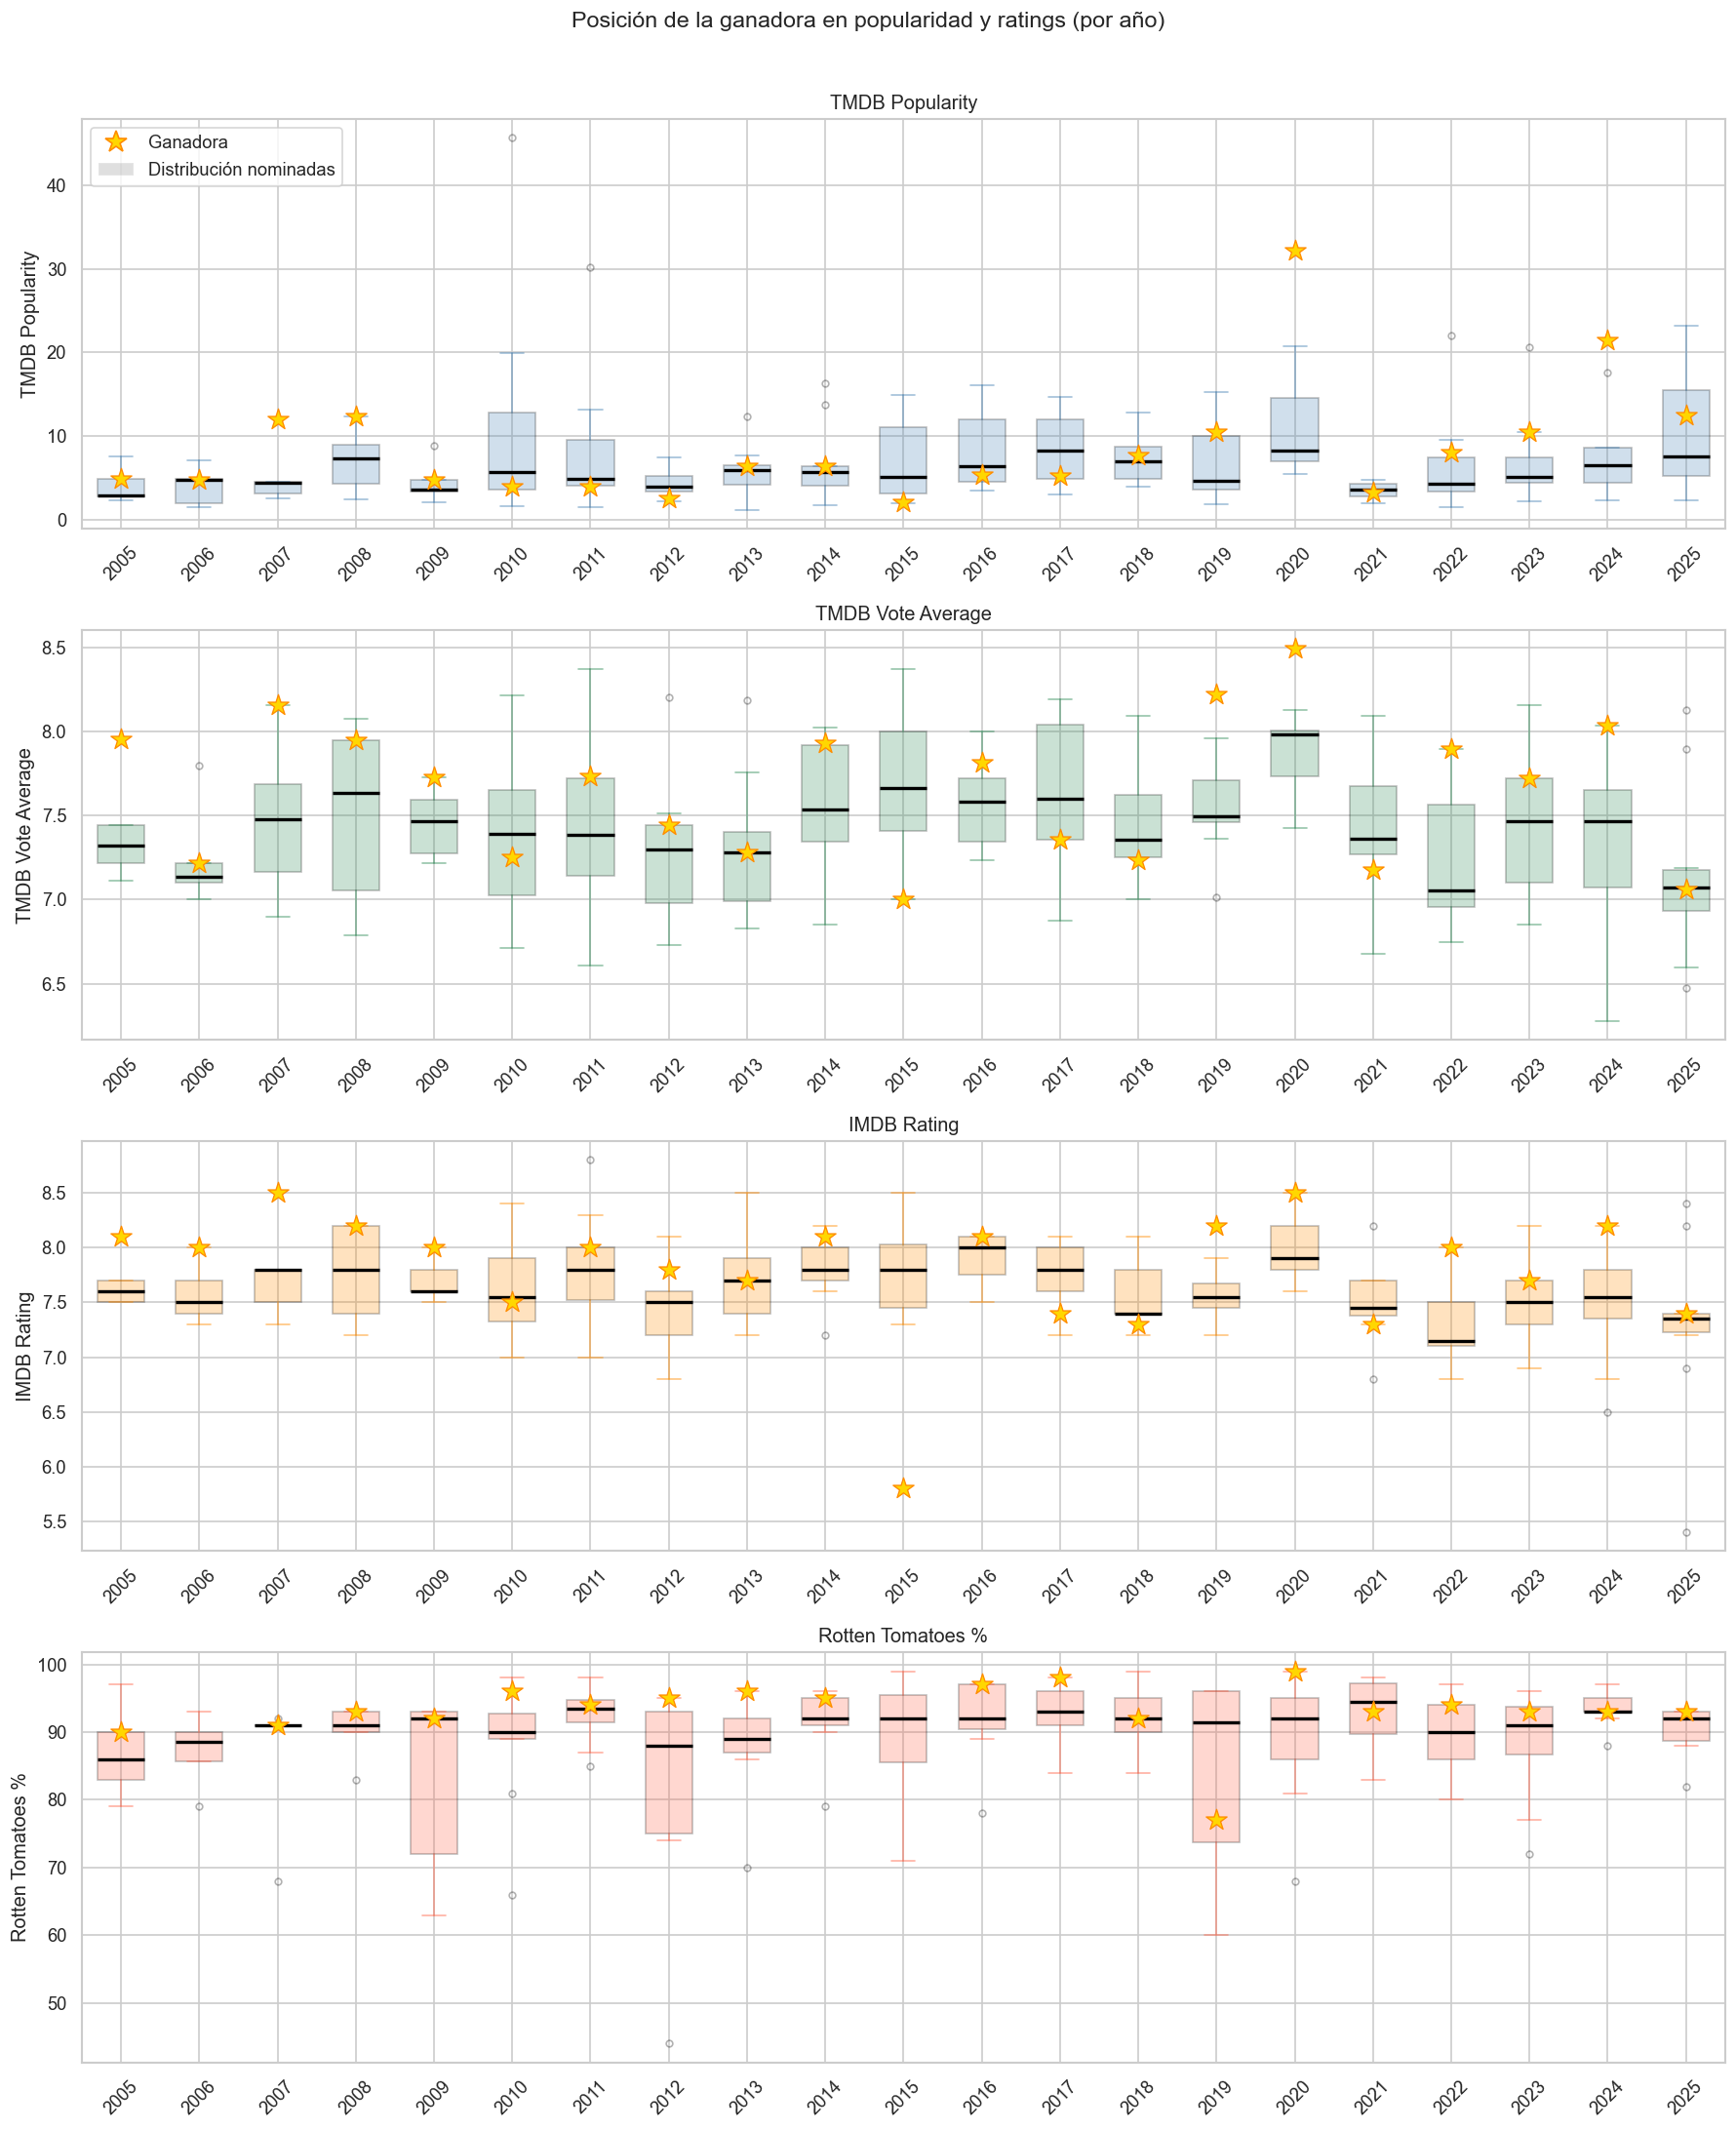

In [26]:
fig, axes = plt.subplots(4, 1, figsize=(15, 18))

metrics = [
    ("tmdb_popularity",  "TMDB Popularity",       "steelblue"),
    ("tmdb_vote_avg",    "TMDB Vote Average",      "seagreen"),
    ("imdb_rating",      "IMDB Rating",            "darkorange"),
    ("rt_score",         "Rotten Tomatoes %",      "tomato"),
]

for ax, (col, title, color) in zip(axes, metrics):
    for year in sorted(df["ceremony_year"].unique()):
        year_df = df[df["ceremony_year"] == year][col].dropna()
        winner  = df[(df["ceremony_year"] == year) & (df["won_best_picture"] == 1)][col]

        if year_df.empty:
            continue

        bp = ax.boxplot(year_df, positions=[year], widths=0.6,
                        patch_artist=True,
                        boxprops=dict(facecolor=color, alpha=0.25),
                        medianprops=dict(color="black", linewidth=2),
                        whiskerprops=dict(color=color, alpha=0.5),
                        capprops=dict(color=color, alpha=0.5),
                        flierprops=dict(marker="o", color=color, alpha=0.3, markersize=4))

        if not winner.empty and pd.notna(winner.values[0]):
            ax.scatter(year, winner.values[0], color="gold", s=180,
                       zorder=5, marker="*", edgecolors="darkorange", linewidth=0.8)

    ax.set_title(title)
    ax.set_ylabel(title)
    ax.set_xticks(sorted(df["ceremony_year"].unique()))
    ax.tick_params(axis="x", rotation=45)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker="*", color="w", markerfacecolor="gold",
           markeredgecolor="darkorange", markersize=14, label="Ganadora"),
    plt.Rectangle((0,0), 1, 1, fc="gray", alpha=0.25, label="Distribución nominadas")
]
axes[0].legend(handles=legend_elements, loc="upper left")

plt.suptitle("Posición de la ganadora en popularidad y ratings (por año)", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

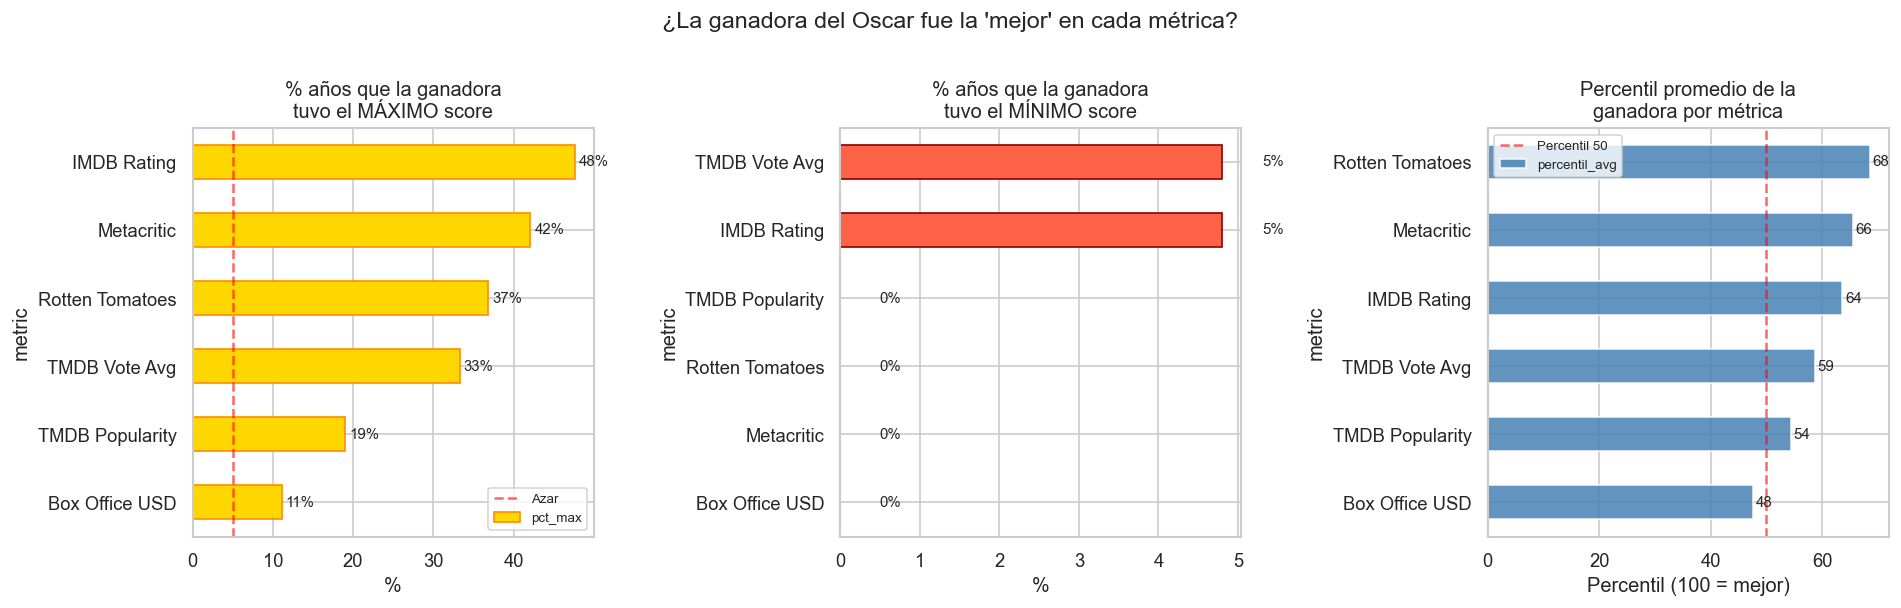

In [ ]:
metrics_rank = [
    ("imdb_rating",     "IMDB Rating"),
    ("rt_score",        "Rotten Tomatoes"),
    ("metacritic",      "Metacritic"),
    ("tmdb_vote_avg",   "TMDB Vote Avg"),
    ("box_office_usd",  "Box Office USD"),
    ("tmdb_popularity", "TMDB Popularity"),
]

results = []
for col, label in metrics_rank:
    for year in sorted(df["ceremony_year"].unique()):
        year_df = df[df["ceremony_year"] == year][[col, "won_best_picture"]].dropna()
        if year_df.empty:
            continue
        winner_val = year_df[year_df["won_best_picture"] == 1][col]
        if winner_val.empty:
            continue
        wval   = winner_val.values[0]
        rank   = (year_df[col] > wval).sum() + 1      # posición (1 = máximo)
        n      = len(year_df)
        is_max = int(rank == 1)
        is_min = int(rank == n)
        results.append({"metric": label, "year": year, "rank": rank,
                        "n": n, "is_max": is_max, "is_min": is_min,
                        "percentile": (1 - rank/n) * 100})

rank_df = pd.DataFrame(results)

summary_rank = rank_df.groupby("metric").agg(
    veces_max    =("is_max", "sum"),
    veces_min    =("is_min", "sum"),
    percentil_avg=("percentile", "mean"),
    total_años   =("year", "count")
).round(1)
summary_rank["pct_max"] = (summary_rank["veces_max"] / summary_rank["total_años"] * 100).round(1)
summary_rank["pct_min"] = (summary_rank["veces_min"] / summary_rank["total_años"] * 100).round(1)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# ── % veces fue el máximo ─────────────────────────────────────────────
ax = axes[0]
summary_rank["pct_max"].sort_values().plot(kind="barh", ax=ax, color="gold", edgecolor="darkorange")
ax.set_title("% años que la ganadora\ntuvo el MÁXIMO score")
ax.set_xlabel("%")
ax.axvline(100/summary_rank["total_años"].mean(), color="red", linestyle="--",
           alpha=0.6, label="Azar")
ax.legend(fontsize=8)
for i, v in enumerate(summary_rank["pct_max"].sort_values()):
    ax.text(v + 0.5, i, f"{v:.0f}%", va="center", fontsize=9)

# ── % veces fue el mínimo ─────────────────────────────────────────────
ax = axes[1]
summary_rank["pct_min"].sort_values().plot(kind="barh", ax=ax, color="tomato", edgecolor="darkred")
ax.set_title("% años que la ganadora\ntuvo el MÍNIMO score")
ax.set_xlabel("%")
for i, v in enumerate(summary_rank["pct_min"].sort_values()):
    ax.text(v + 0.5, i, f"{v:.0f}%", va="center", fontsize=9)

# ── Percentil promedio ────────────────────────────────────────────────
ax = axes[2]
summary_rank["percentil_avg"].sort_values().plot(kind="barh", ax=ax,
                                                  color="steelblue", alpha=0.85)
ax.axvline(50, color="red", linestyle="--", alpha=0.6, label="Percentil 50")
ax.set_title("Percentil promedio de la\nganadora por métrica")
ax.set_xlabel("Percentil (100 = mejor)")
ax.legend(fontsize=8)
for i, v in enumerate(summary_rank["percentil_avg"].sort_values()):
    ax.text(v + 0.5, i, f"{v:.0f}", va="center", fontsize=9)

plt.suptitle("¿La ganadora del Oscar fue la 'mejor' en cada métrica?", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

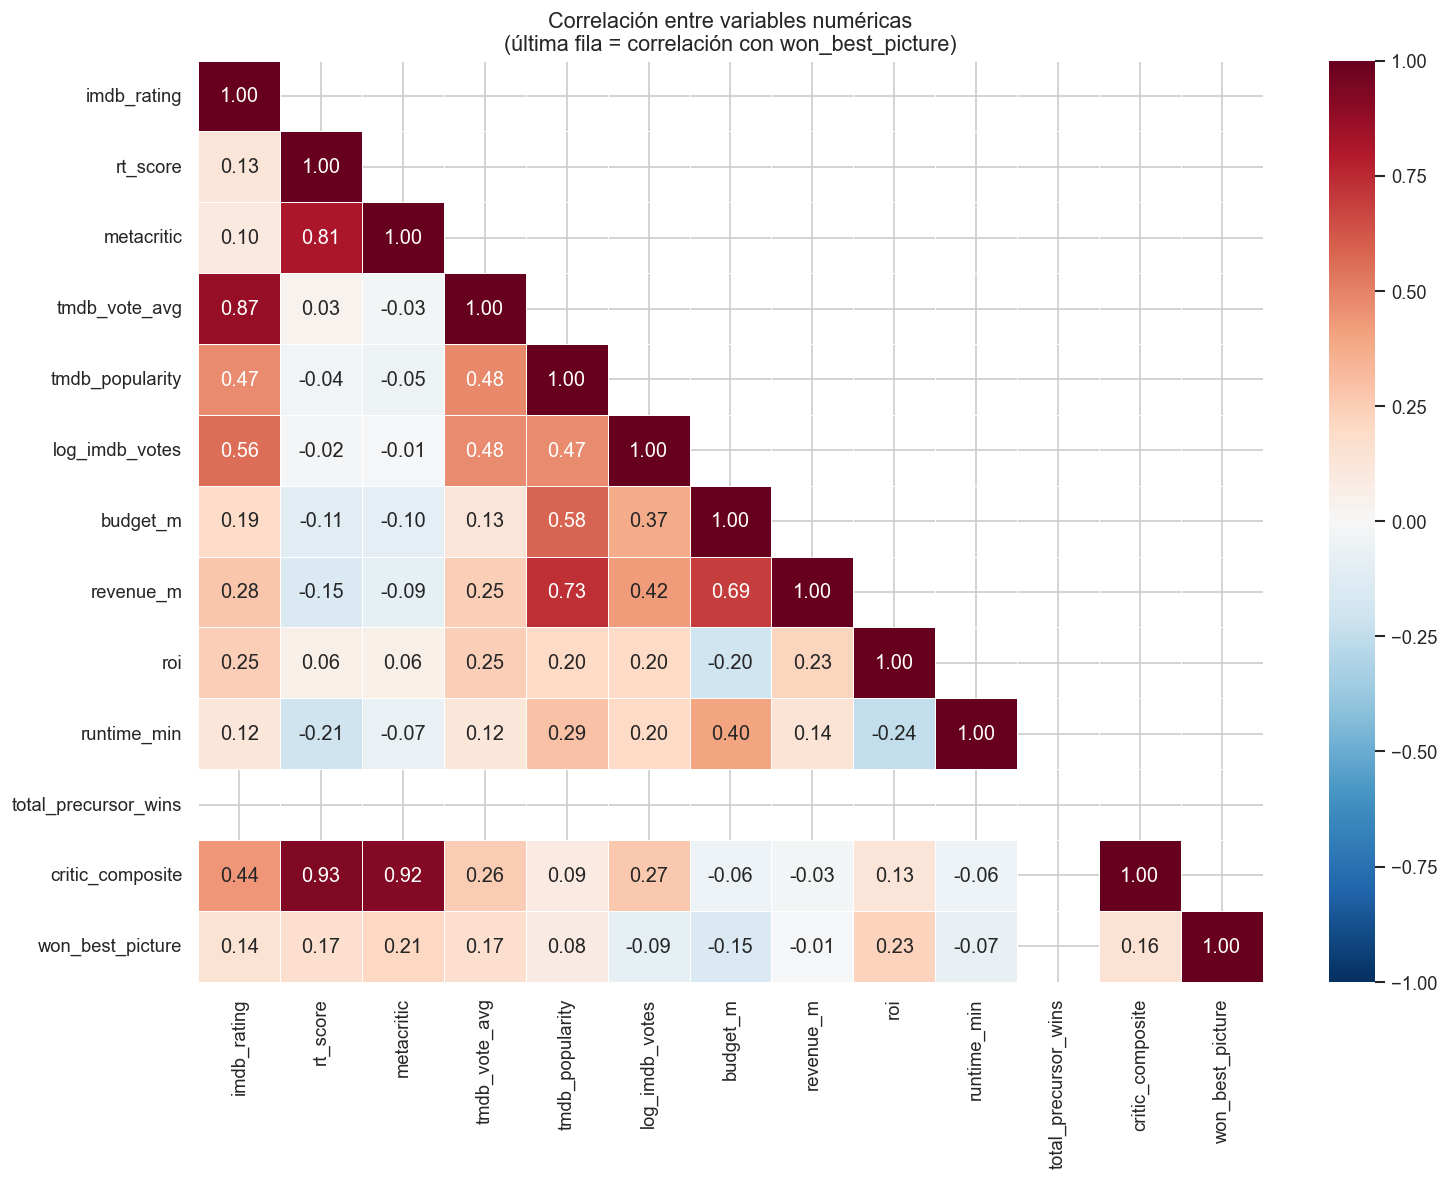


── Top correlaciones con won_best_picture ──
roi                     0.230511
metacritic              0.207262
tmdb_vote_avg           0.170717
rt_score                0.170137
critic_composite        0.156202
budget_m               -0.150235
imdb_rating             0.141293
log_imdb_votes         -0.087512
tmdb_popularity         0.078132
runtime_min            -0.073755
revenue_m              -0.011369
total_precursor_wins         NaN


In [31]:
num_cols = [
    "imdb_rating", "rt_score", "metacritic", "tmdb_vote_avg",
    "tmdb_popularity", "log_imdb_votes", "budget_m", "revenue_m",
    "roi", "runtime_min", "total_precursor_wins", "critic_composite",
    "won_best_picture"
]

corr = df[num_cols].corr()

fig, ax = plt.subplots(figsize=(13, 10))
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)  # mostrar todo (triangulo inferior)
sns.heatmap(corr, ax=ax, annot=True, fmt=".2f", cmap="RdBu_r",
            center=0, linewidths=0.5, mask=np.triu(np.ones_like(corr, dtype=bool), k=1),
            vmin=-1, vmax=1)
ax.set_title("Correlación entre variables numéricas\n(última fila = correlación con won_best_picture)",
             fontsize=13)
plt.tight_layout()
plt.show()

# Top correlaciones con el target
print("\n── Top correlaciones con won_best_picture ──")
target_corr = corr["won_best_picture"].drop("won_best_picture").sort_values(key=abs, ascending=False)
print(target_corr.to_string())

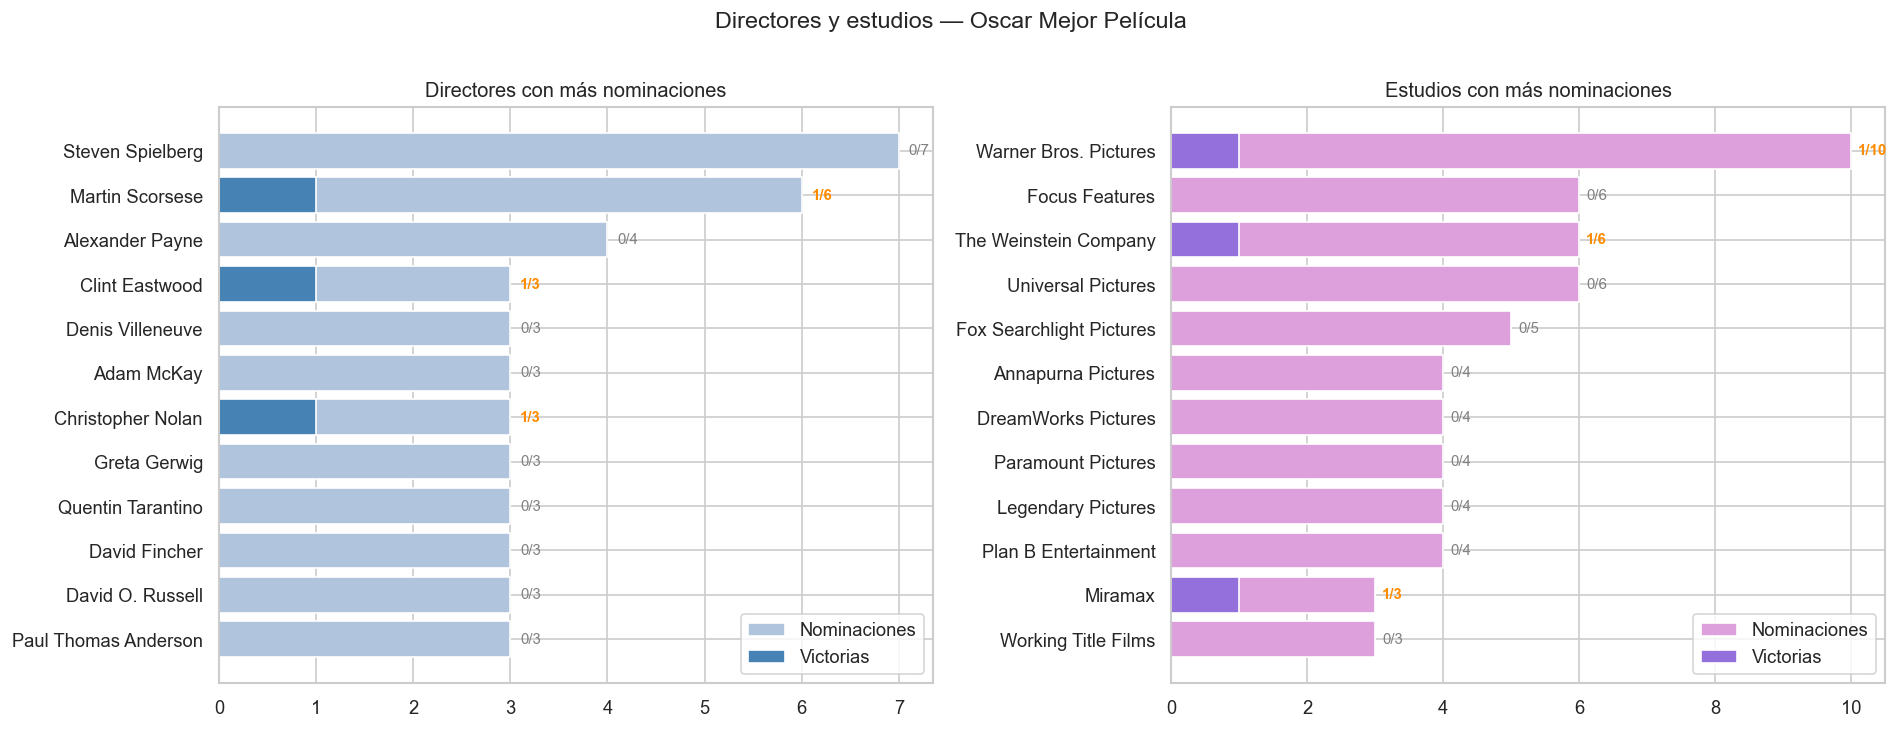

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ── Directores con más nominaciones ──────────────────────────────────
ax = axes[0]
dir_summary = df.groupby("director").agg(
    nominaciones=("won_best_picture", "count"),
    victorias   =("won_best_picture", "sum")
).sort_values("nominaciones", ascending=False).head(12)

x = np.arange(len(dir_summary))
width = 0.35
ax.barh(dir_summary.index, dir_summary["nominaciones"], color="lightsteelblue", label="Nominaciones")
ax.barh(dir_summary.index, dir_summary["victorias"],    color="steelblue",      label="Victorias")
ax.invert_yaxis()
ax.set_title("Directores con más nominaciones")
ax.legend()
for i, (nom, vic) in enumerate(zip(dir_summary["nominaciones"], dir_summary["victorias"])):
    ax.text(nom + 0.1, i, f"{int(vic)}/{int(nom)}", va="center", fontsize=9,
            color="darkorange" if vic > 0 else "gray", fontweight="bold" if vic > 0 else "normal")

# ── Estudios con más nominaciones ─────────────────────────────────────
ax = axes[1]
df["primary_studio"] = df["production_companies"].apply(
    lambda x: json.loads(x)[0] if pd.notna(x) and x != "[]" else "Unknown"
)
studio_summary = df.groupby("primary_studio").agg(
    nominaciones=("won_best_picture", "count"),
    victorias   =("won_best_picture", "sum")
).sort_values("nominaciones", ascending=False).head(12)

ax.barh(studio_summary.index, studio_summary["nominaciones"], color="plum",      label="Nominaciones")
ax.barh(studio_summary.index, studio_summary["victorias"],    color="mediumpurple", label="Victorias")
ax.invert_yaxis()
ax.set_title("Estudios con más nominaciones")
ax.legend()
for i, (nom, vic) in enumerate(zip(studio_summary["nominaciones"], studio_summary["victorias"])):
    ax.text(nom + 0.1, i, f"{int(vic)}/{int(nom)}", va="center", fontsize=9,
            color="darkorange" if vic > 0 else "gray", fontweight="bold" if vic > 0 else "normal")

plt.suptitle("Directores y estudios — Oscar Mejor Película", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

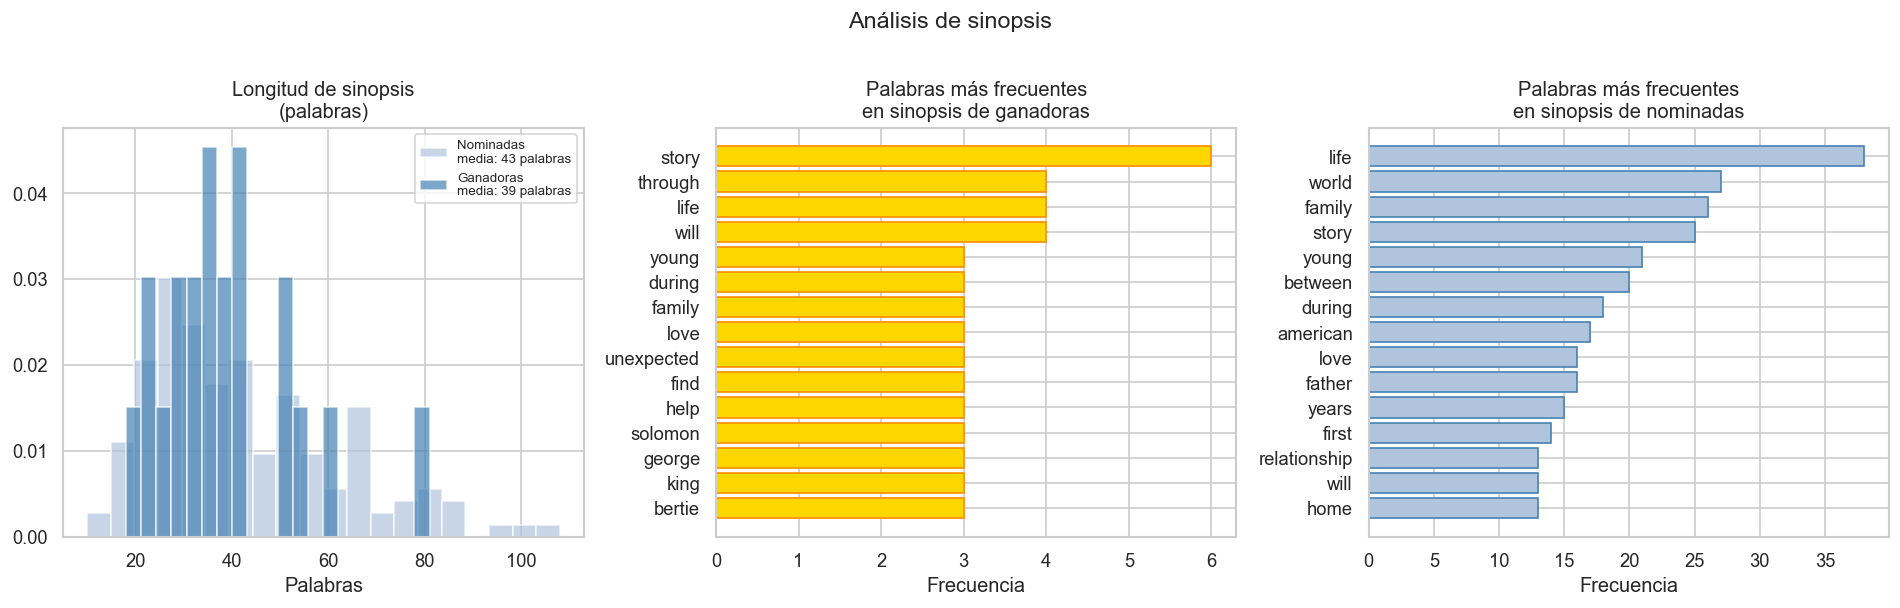

In [33]:
from collections import Counter
import re

# Longitud de sinopsis
df["synopsis_len"]   = df["synopsis"].fillna("").apply(len)
df["synopsis_words"] = df["synopsis"].fillna("").apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# ── Longitud: winners vs nominadas ────────────────────────────────────
ax = axes[0]
for won, label, color in [(0, "Nominadas", "lightsteelblue"), (1, "Ganadoras", "steelblue")]:
    sub = df[df["won_best_picture"] == won]["synopsis_words"]
    ax.hist(sub, bins=20, alpha=0.7, color=color, density=True,
            label=f"{label}\nmedia: {sub.mean():.0f} palabras")
ax.set_title("Longitud de sinopsis\n(palabras)")
ax.set_xlabel("Palabras")
ax.legend(fontsize=8)

# ── Palabras más frecuentes en ganadoras ──────────────────────────────
ax = axes[1]
stopwords = {"a", "an", "the", "and", "or", "but", "in", "on", "at", "to",
             "for", "of", "with", "his", "her", "their", "is", "are", "was",
             "were", "he", "she", "they", "who", "when", "after", "while",
             "as", "by", "from", "it", "its", "be", "has", "have", "been",
             "that", "this", "which", "not", "no", "into", "after", "two"}

def top_words(subdf, n=15):
    text = " ".join(subdf["synopsis"].fillna("")).lower()
    words = re.findall(r"\b[a-z]{4,}\b", text)
    return Counter(w for w in words if w not in stopwords).most_common(n)

winners_words = pd.DataFrame(top_words(df[df["won_best_picture"] == 1]),
                              columns=["word", "count"])
ax.barh(winners_words["word"], winners_words["count"], color="gold", edgecolor="darkorange")
ax.invert_yaxis()
ax.set_title("Palabras más frecuentes\nen sinopsis de ganadoras")
ax.set_xlabel("Frecuencia")

# ── Palabras más frecuentes en NO ganadoras ───────────────────────────
ax = axes[2]
losers_words = pd.DataFrame(top_words(df[df["won_best_picture"] == 0]),
                             columns=["word", "count"])
ax.barh(losers_words["word"], losers_words["count"], color="lightsteelblue", edgecolor="steelblue")
ax.invert_yaxis()
ax.set_title("Palabras más frecuentes\nen sinopsis de nominadas")
ax.set_xlabel("Frecuencia")

plt.suptitle("Análisis de sinopsis", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()